In [173]:
# # Do not forget to check if your notebook log collection plugin is working
from mining_extension import check_logging
check_logging("http://3.249.245.244:9999")

Request successful!


In [174]:
# !pip install pandas

In [175]:
# !pip install scikit-learn

In [176]:
# !pip install catboost
# !pip install xgboost

In [5]:
# pip install alive-progress

In [6]:
# !pip install tqdm

In [7]:
import pandas as pd
import sklearn
import catboost
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import numpy as np

In [8]:
import time
from tqdm import tqdm
import gc


In [9]:
import zipfile
with zipfile.ZipFile('data/task1/jetnet_logs.zip', 'r') as zip_ref:
    zip_ref.extractall('data/task1')

# Data Engineering

In [10]:
data = pd.read_csv('data/task1/jetnet_logs.txt', delimiter='\t')
data.head()

,@User92: Action_3 (15/10/19 | 18:08:02) -> Action_1 (15/10/19 | 18:54:49) -> Action_10 (15/10/19 | 20:02:54) -> Action_7 (15/10/19 | 20:26:56) -> Action_0 (15/10/19 | 20:51:09) -> Action_3 (15/10/19 | 22:00:47) -> Action_0 (15/10/19 | 22:49:59) -> Action_7 (15/10/19 | 23:08:43) -> Action_7 (15/10/19 | 23:51:57) -> Action_4 (16/10/19 | 00:10:14) -> Action_8 (16/10/19 | 00:28:14) -> Action_7 (16/10/19 | 01:04:24) -> Action_7 (16/10/19 | 00:47:45) -> Action_3 (16/10/19 | 00:34:58) -> Action_10 (16/10/19 | 00:50:19) -> Action_1 (16/10/19 | 00:54:43) -> Action_1 (16/10/19 | 01:32:37) -> Action_4 (16/10/19 | 01:39:53) -> Action_8 (16/10/19 | 01:35:39) -> Action_5 (16/10/19 | 02:41:46) -> Action_10 (16/10/19 | 03:06:10) --> Action_1 (16/10/19 | 03:37:28) -> Action_8 (16/10/19 | 03:33:07) -> Action_10 (16/10/19 | 03:49:30) -> Action_7 (16/10/19 | 04:22:15) -> Action_0 (16/10/19 | 04:23:57) -> Action_3 (16/10/19 | 05:03:15) ->
0,@User140: Action_3 (15/05/20 | 15:37:04) -> Ac...
1,@User105: Action_4 (25/04/20 | 01:08:29) -> Ac...
2,@User127: Action_1 (20/06/20 | 00:24:48) -> Ac...
3,@User50: Action_4 (09/10/19 | 15:12:52) --> Ac...
4,@User51: Action_3 (09/01/20 | 18:19:40) -> Act...


In [11]:
with open('data/task1/jetnet_logs.txt') as f:
    content = f.readline()

In [12]:
l = content.strip().split(":", 1)
# print(l[1])
l[1] = l[1].replace('-->', '->').strip().split('->')
# print(l[1])
l[1] = list(map(lambda x: x.strip().split(" ", 1), l[1]))
# actions = [t[0] for t in l[1]]
# timestamps = [t[1] for t in l[1]]
l

['@User92',
 [['Action_3', '(15/10/19 | 18:08:02)'],
  ['Action_1', '(15/10/19 | 18:54:49)'],
  ['Action_10', '(15/10/19 | 20:02:54)'],
  ['Action_7', '(15/10/19 | 20:26:56)'],
  ['Action_0', '(15/10/19 | 20:51:09)'],
  ['Action_3', '(15/10/19 | 22:00:47)'],
  ['Action_0', '(15/10/19 | 22:49:59)'],
  ['Action_7', '(15/10/19 | 23:08:43)'],
  ['Action_7', '(15/10/19 | 23:51:57)'],
  ['Action_4', '(16/10/19 | 00:10:14)'],
  ['Action_8', '(16/10/19 | 00:28:14)'],
  ['Action_7', '(16/10/19 | 01:04:24)'],
  ['Action_7', '(16/10/19 | 00:47:45)'],
  ['Action_3', '(16/10/19 | 00:34:58)'],
  ['Action_10', '(16/10/19 | 00:50:19)'],
  ['Action_1', '(16/10/19 | 00:54:43)'],
  ['Action_1', '(16/10/19 | 01:32:37)'],
  ['Action_4', '(16/10/19 | 01:39:53)'],
  ['Action_8', '(16/10/19 | 01:35:39)'],
  ['Action_5', '(16/10/19 | 02:41:46)'],
  ['Action_10', '(16/10/19 | 03:06:10)'],
  ['Action_1', '(16/10/19 | 03:37:28)'],
  ['Action_8', '(16/10/19 | 03:33:07)'],
  ['Action_10', '(16/10/19 | 03:49:30)'],


In [20]:
f = open('data/task1/jetnet_logs.txt')
lines = f.readlines()
columns = ['user_id', 'session_num', 'action_time','action_name']
df = pd.DataFrame([], columns = columns)
df

,user_id,session_num,action_time,action_name


In [192]:
d = []
session = 0
for n, line in tqdm(enumerate(np.array(lines))):
#     if n > 500: break
    line = line.strip()
    if line:
        l = line.split(":", 1)
        ids = l[0].replace('@', '')
        l = l[1]
        l = l.replace('-->', '\t').replace('->', '\t').strip().split('\t')
        for i, action in enumerate(np.array(l)):
            action = action.strip().split(" ", 1)
            data = [ids, -1, '', '']
            if len(action) == 2:
                data[1]= session
                data[2] = action[1].strip()[1:-1]
                data[3] = action[0].strip()
            d.append(data)
    session+=1

87192it [00:05, 15993.04it/s]


In [193]:
df = pd.DataFrame(d, columns = columns)
df

,user_id,session_num,action_time,action_name
0,User92,0,15/10/19 | 18:08:02,Action_3
1,User92,0,15/10/19 | 18:54:49,Action_1
2,User92,0,15/10/19 | 20:02:54,Action_10
3,User92,0,15/10/19 | 20:26:56,Action_7
4,User92,0,15/10/19 | 20:51:09,Action_0
...,...,...,...,...
2053478,User112,87190,08/07/21 | 03:18:55,END
2053479,User76,87191,28/07/21 | 14:35:47,Action_7
2053480,User76,87191,28/07/21 | 15:09:53,Action_9
2053481,User76,87191,28/07/21 | 14:59:10,Action_1


filtration

In [194]:
df.isnull().sum()

user_id        0
session_num    0
action_time    0
action_name    0
dtype: int64

In [198]:
t = df['action_time'].str.match(r'^((\d{2}|\d)/\d{2}/\d{2} \| \d{2}:\d{2}:\d{2}$)')
np.where(t == False)[0]
df['action_time'][np.where(t == False)[0]]

1797       null
2451       null
4098       null
4253       null
4332           
           ... 
2050042    null
2050753    null
2051255    null
2051586    null
2051769    null
Name: action_time, Length: 2545, dtype: object

In [199]:
df_new = df.drop(np.where(t == False)[0])

In [202]:
df_new['action_time'].str.match(r'^((\d{2}|\d)/\d{2}/\d{2} \| \d{2}:\d{2}:\d{2}$)').all()

True

In [203]:
from datetime import datetime as dt

In [204]:
f = '%d/%m/%y | %H:%M:%S'
f2 = '%Y-%m-%d %H:%M:%S'
def to_datetime(x): 
    try: return dt.strptime(x, f) 
    except: return None
#     except: return x
df_new['datetime'] = df_new['action_time'].apply(to_datetime)

In [205]:
df_new.isna().sum()

user_id          0
session_num      0
action_time      0
action_name      0
datetime       229
dtype: int64

In [206]:
df_new = df_new.dropna()

In [208]:
df_new

,user_id,session_num,action_time,action_name,datetime
0,User92,0,15/10/19 | 18:08:02,Action_3,2019-10-15 18:08:02
1,User92,0,15/10/19 | 18:54:49,Action_1,2019-10-15 18:54:49
2,User92,0,15/10/19 | 20:02:54,Action_10,2019-10-15 20:02:54
3,User92,0,15/10/19 | 20:26:56,Action_7,2019-10-15 20:26:56
4,User92,0,15/10/19 | 20:51:09,Action_0,2019-10-15 20:51:09
...,...,...,...,...,...
2053478,User112,87190,08/07/21 | 03:18:55,END,2021-07-08 03:18:55
2053479,User76,87191,28/07/21 | 14:35:47,Action_7,2021-07-28 14:35:47
2053480,User76,87191,28/07/21 | 15:09:53,Action_9,2021-07-28 15:09:53
2053481,User76,87191,28/07/21 | 14:59:10,Action_1,2021-07-28 14:59:10


# Metrics Evaluation

In [209]:
import math

## Mean actions count per user overall

In [210]:
df.groupby('user_id')['action_name'].count()

user_id
User0      12148
User1      28900
User10       665
User100     1138
User101    19353
           ...  
User95     15739
User96     15433
User97     12773
User98       638
User99      3397
Name: action_name, Length: 143, dtype: int64

### ansewer

In [211]:
sum(df.groupby('user_id')['action_name'].count())/len(df['user_id'].unique())

14360.02097902098

## Mean actions by user in a day

In [212]:
df_new['day'] = df_new['datetime'].apply(lambda x: x.date().toordinal())

In [213]:
df_new

,user_id,session_num,action_time,action_name,datetime,day
0,User92,0,15/10/19 | 18:08:02,Action_3,2019-10-15 18:08:02,737347
1,User92,0,15/10/19 | 18:54:49,Action_1,2019-10-15 18:54:49,737347
2,User92,0,15/10/19 | 20:02:54,Action_10,2019-10-15 20:02:54,737347
3,User92,0,15/10/19 | 20:26:56,Action_7,2019-10-15 20:26:56,737347
4,User92,0,15/10/19 | 20:51:09,Action_0,2019-10-15 20:51:09,737347
...,...,...,...,...,...,...
2053478,User112,87190,08/07/21 | 03:18:55,END,2021-07-08 03:18:55,737979
2053479,User76,87191,28/07/21 | 14:35:47,Action_7,2021-07-28 14:35:47,737999
2053480,User76,87191,28/07/21 | 15:09:53,Action_9,2021-07-28 15:09:53,737999
2053481,User76,87191,28/07/21 | 14:59:10,Action_1,2021-07-28 14:59:10,737999


In [214]:
t = df_new.groupby(['user_id', 'day'])['action_name'].count()
t

user_id  day   
User0    737304     1
         737323    45
         737324    40
         737325     7
         737326    13
                   ..
User99   738037    50
         738038    10
         738041    19
         738042    13
         738043    16
Name: action_name, Length: 69762, dtype: int64

### ansewer

In [215]:
sum(t)/len(t)

29.395788538172646

## The probability of repeating the same action three times in a row during one session

In [220]:
grouped_data = df.groupby(['user_id', 'session_num'])

In [228]:
mask = (grouped_data['action_name'].shift() == df['action_name']) & (grouped_data['action_name'].shift(-1) == df['action_name'])
total_sessions = grouped_data['session_num'].nunique().count()
repeated_sessions = mask.any().sum()
probability = repeated_sessions / total_sessions

In [239]:
sh = []
for i in np.where(mask == True)[0]:
    sh.append(i-1)
    sh.append(i)
    sh.append(i+1)

In [243]:
df['action_name'][sh].head(18)

210    Action_3
211    Action_3
212    Action_3
329    Action_7
330    Action_7
331    Action_7
380    Action_3
381    Action_3
382    Action_3
447    Action_7
448    Action_7
449    Action_7
522    Action_7
523    Action_7
524    Action_7
593    Action_7
594    Action_7
595    Action_7
Name: action_name, dtype: object

### answer

In [227]:
print(probability)

1.1474337643859509e-05


## The 0.95 quantile of distribution of time delta between the actions of the same type distribution during one session 

In [245]:
df_new['timestamp'] = df_new['datetime'].apply(lambda x: x.timestamp())

In [255]:
grouped_data = df_new.groupby(['user_id', 'session_num'])
time_deltas = grouped_data['timestamp'].diff()
time_deltas = time_deltas.dropna()
time_deltas

1          2807.0
2          4085.0
3          1442.0
4          1453.0
5          4178.0
            ...  
2053477    1157.0
2053478    1234.0
2053480    2046.0
2053481    -643.0
2053482    2541.0
Name: timestamp, Length: 1963624, dtype: float64

In [253]:
same_type_time_deltas = time_deltas[df['action_name'].eq(df['action_name'].shift())]
same_type_time_deltas

8          2594.0
12         -999.0
16         2274.0
34         1469.0
40         2120.0
            ...  
2053439     279.0
2053443    3592.0
2053449    2268.0
2053469     530.0
2053470    2269.0
Name: timestamp, Length: 257106, dtype: float64

In [256]:
quantile_95 = np.quantile(same_type_time_deltas, 0.95)

### answer

In [258]:
print(f'Answer is: \n{quantile_95} seconds\nor\n{quantile_95/60} minutes')

Answer is: 
4278.0 seconds
or
71.3 minutes


## Is there statistical difference of activity in different days of the week? And between weekends and workdays? 

In [259]:
df_new['weekday'] = df_new['datetime'].apply(lambda x: x.weekday())

In [273]:
grouped_data = df_new.groupby('weekday')['action_name'].count()
grouped_data

weekday
0    287383
1    292354
2    294519
3    291829
4    293430
5    296003
6    295191
Name: action_name, dtype: int64

In [282]:
[grouped_data[day] for day in range(7)]

[287383, 292354, 294519, 291829, 293430, 296003, 295191]

In [ ]:
from scipy.stats import chi2_contingency, ttest_ind
weekends = df_new.loc[df_new['weekday'].isin([5, 6]), ['action_name']]
workdays = df_new.loc[~df_new['weekday'].isin([5, 6]), ['action_name']]

# Perform t-test for comparing activity counts between weekends and workdays
t_statistic, p_value = ttest_ind(weekends, workdays)

print("Chi-square test p-value:", p_value)
print("T-test p-value:", p_value)

### answer

# Data Visualisation

## the time series (line plot) of count of different actions by days

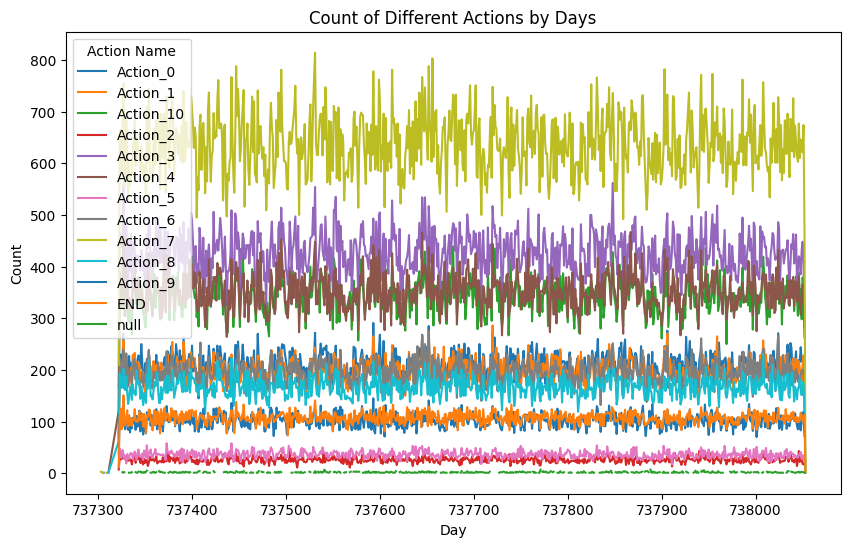

In [48]:
action_counts = df_new.groupby(['day', 'action_name']).size().reset_index(name='count')
pivot_table = action_counts.pivot(index='day', columns='action_name', values='count')

pivot_table.plot(kind='line', figsize=(10, 6))

plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Count of Different Actions by Days')
plt.legend(title='Action Name')

plt.show()

## the barchart of different actions counts

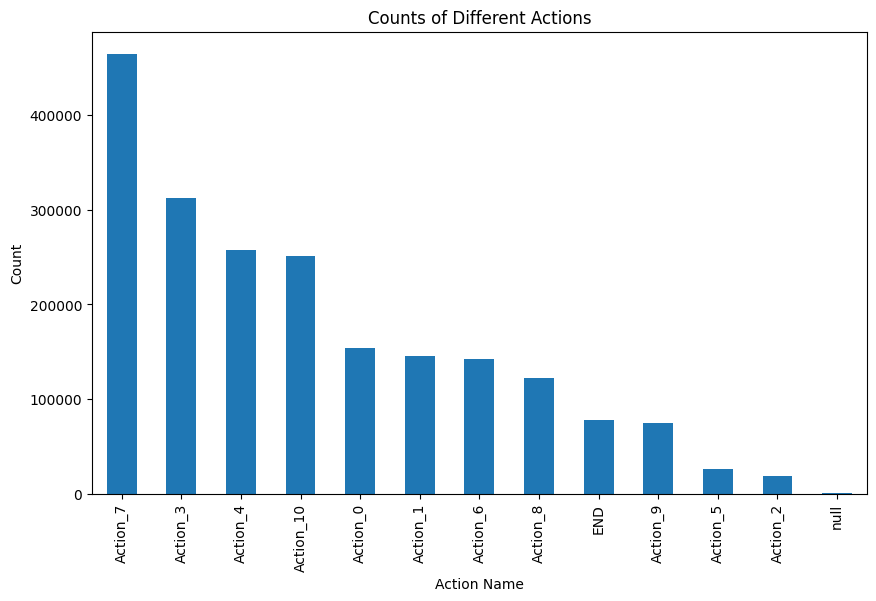

In [52]:
action_counts = df_new['action_name'].value_counts()

action_counts.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Action Name')
plt.ylabel('Count')
plt.title('Counts of Different Actions')

plt.show()